In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/CircuitRecognitioncoco/train")
count_images("datasets/CircuitRecognitioncoco/valid")

Total images: 2652
Total images: 400


In [3]:
# Check train annotations
with open("datasets/CircuitRecognitioncoco/train/_annotations.coco.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/CircuitRecognitioncoco/valid/_annotations.coco.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")

Train images: 2652
Train annotations: 14749
Categories: [{'id': 0, 'name': 'Predict-circuit-parameters', 'supercategory': 'none'}, {'id': 1, 'name': 'acv', 'supercategory': 'Predict-circuit-parameters'}, {'id': 2, 'name': 'c', 'supercategory': 'Predict-circuit-parameters'}, {'id': 3, 'name': 'i', 'supercategory': 'Predict-circuit-parameters'}, {'id': 4, 'name': 'l', 'supercategory': 'Predict-circuit-parameters'}, {'id': 5, 'name': 'r', 'supercategory': 'Predict-circuit-parameters'}, {'id': 6, 'name': 'v', 'supercategory': 'Predict-circuit-parameters'}]

Valid images: 400
Valid annotations: 2208


In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [6]:
from detectron2.data.datasets import register_coco_instances
import os

data_dir = "datasets/CircuitRecognitioncoco"

register_coco_instances("circuit_train", {},
                        os.path.join(data_dir, "train/_annotations.coco.json"),
                        os.path.join(data_dir, "train"))

register_coco_instances("circuit_val", {},
                        os.path.join(data_dir, "valid/_annotations.coco.json"),
                        os.path.join(data_dir, "valid"))

In [7]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

# Use Faster R-CNN with ResNet-50
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Dataset
cfg.DATASETS.TRAIN = ("circuit_train",)
cfg.DATASETS.TEST = ("circuit_val",)
cfg.DATALOADER.NUM_WORKERS = 4

# Training setup
cfg.SOLVER.IMS_PER_BATCH = 8
num_images = 2652
epochs = 10
iters_per_epoch = num_images // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
# Dynamic LR step schedule (50% and 80% of total iters)
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = (
    int(cfg.SOLVER.MAX_ITER * 0.5),
    int(cfg.SOLVER.MAX_ITER * 0.8)
)
# Evaluate every 5 epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * 5 # 5 epoch
cfg.SOLVER.GAMMA = 0.1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

cfg.SOLVER.CHECKPOINT_PERIOD = 250
cfg.OUTPUT_DIR = "/content/.cache/detectron2_circuit"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [8]:
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
import torch

from detectron2.evaluation import inference_on_dataset

class BestModelSaver(hooks.EvalHook):
    def __init__(self, eval_period, model, evaluator, val_loader, save_path):
        self.model = model
        self.evaluator = evaluator
        self.val_loader = val_loader
        self.save_path = save_path
        self.best_ap = -1

        def eval_function():
            results = inference_on_dataset(self.model, self.val_loader, self.evaluator)
            if results:
                curr_ap = results["bbox"]["AP"]
                print(f"📈 Eval AP: {curr_ap:.4f} | Best so far: {self.best_ap:.4f}")
                if curr_ap > self.best_ap:
                    print(f"🥇 New best model! Saving to {self.save_path}")
                    torch.save(self.model.state_dict(), self.save_path)
                    self.best_ap = curr_ap
            return results

        super().__init__(eval_period, eval_function)

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from pycocotools.coco import COCO
import copy

class SafeCOCOEvaluator(COCOEvaluator):
    def _evaluate_predictions_on_coco(self, coco_gt: COCO, coco_results, iou_type):
        # 🔧 Patch missing fields to prevent crashing
        coco_gt.dataset.setdefault("info", {})
        coco_gt.dataset.setdefault("licenses", [])
        coco_gt.createIndex()  # Ensure internal COCO indexing is rebuilt

        coco_dt = coco_gt.loadRes(coco_results)
        return super()._evaluate_predictions_on_coco(coco_gt, coco_dt, iou_type)

In [ ]:
torch.cuda.empty_cache()

In [10]:
from pycocotools.coco import COCO
import copy
import json
import time

def patched_loadRes(self, resFile):
    tic = time.time()  # <-- ✅ define it properly now

    # Ensure required dataset fields exist
    if 'info' not in self.dataset:
        self.dataset['info'] = {}
    if 'licenses' not in self.dataset:
        self.dataset['licenses'] = []

    # Load annotation results from file or list
    if isinstance(resFile, str):
        with open(resFile, 'r') as f:
            anns = json.load(f)
    elif isinstance(resFile, list):
        anns = resFile
    else:
        raise TypeError('resFile must be a file path or list of dicts')

    res = COCO()
    res.dataset['info'] = copy.deepcopy(self.dataset['info'])
    res.dataset['licenses'] = copy.deepcopy(self.dataset['licenses'])
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])

    assert isinstance(anns, list), 'Annotations must be a list'
    anns_img_ids = [ann['image_id'] for ann in anns]
    assert set(anns_img_ids).issubset(set(self.getImgIds()))

    # Add missing 'id' and 'area' fields in each annotation
    for idx, ann in enumerate(anns):
        ann.setdefault('id', idx + 1)
        if 'area' not in ann:
            if 'bbox' in ann:
                _, _, w, h = ann['bbox']
                ann['area'] = w * h
            else:
                ann['area'] = 0

    res.dataset['annotations'] = anns
    res.createIndex()
    print(f'Annotations loaded in {time.time() - tic:.2f}s')
    return res

# ✅ Monkey-patch the method
COCO.loadRes = patched_loadRes

In [11]:
from detectron2.data import build_detection_test_loader

trainer = DefaultTrainer(cfg)

val_loader = build_detection_test_loader(cfg, "circuit_val")
evaluator = SafeCOCOEvaluator("circuit_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
best_model_path = "datasets/best_fasterrcnn_model.pth"

trainer.register_hooks([
    BestModelSaver(cfg.TEST.EVAL_PERIOD, trainer.model, evaluator, val_loader, best_model_path)
])

[02/09 21:09:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
trainer.resume_or_load(resume=True)
trainer.train()

[02/09 18:19:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


model_final_280758.pkl: 167MB [00:02, 57.5MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/09 18:19:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
W0209 18:19:25.582000 2024 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[02/09 18:20:04 d2.utils.events]:  eta: 1:47:58  iter: 19  total_loss: 3.218  loss_cls: 2.169  loss_box_reg: 0.4371  loss_rpn_cls: 0.5864  loss_rpn_loc: 0.05385    time: 1.9755  last_time: 2.0712  data_time: 0.2015  last_data_time: 0.3302   lr: 4.9953e-06  max_mem: 11351M
[02/09 18:20:53 d2.utils.events]:  eta: 1:53:57  iter: 39  total_loss: 3.049  loss_cls: 2.006  loss_box_reg: 0.5509  loss_rpn_cls: 0.4496  loss_rpn_loc: 0.04755    time: 2.0471  last_time: 2.3065  data_time: 0.2177  last_data_time: 0.2145   lr: 9.9903e-06  max_mem: 11351M
[02/09 18:21:35 d2.utils.events]:  eta: 1:54:27  iter: 59  total_loss: 2.831  loss_cls: 1.747  loss_box_reg: 0.7397  loss_rpn_cls: 0.2908  loss_rpn_loc: 0.04968    time: 2.0612  last_time: 2.3141  data_time: 0.1531  last_data_time: 0.3575   lr: 1.4985e-05  max_mem: 11353M
[02/09 18:22:18 d2.utils.events]:  eta: 1:54:22  iter: 79  total_loss: 2.488  loss_cls: 1.479  loss_box_reg: 0.8099  loss_rpn_cls: 0.1461  loss_rpn_loc: 0.04277    time: 2.0797  las

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[02/09 19:16:24 d2.evaluation.evaluator]: Inference done 11/400. Dataloading: 0.0019 s/iter. Inference: 0.1032 s/iter. Eval: 0.0003 s/iter. Total: 0.1053 s/iter. ETA=0:00:40
[02/09 19:16:29 d2.evaluation.evaluator]: Inference done 60/400. Dataloading: 0.0019 s/iter. Inference: 0.1007 s/iter. Eval: 0.0003 s/iter. Total: 0.1029 s/iter. ETA=0:00:34
[02/09 19:16:34 d2.evaluation.evaluator]: Inference done 108/400. Dataloading: 0.0022 s/iter. Inference: 0.1012 s/iter. Eval: 0.0003 s/iter. Total: 0.1037 s/iter. ETA=0:00:30
[02/09 19:16:39 d2.evaluation.evaluator]: Inference done 158/400. Dataloading: 0.0020 s/iter. Inference: 0.1005 s/iter. Eval: 0.0003 s/iter. Total: 0.1029 s/iter. ETA=0:00:24
[02/09 19:16:44 d2.evaluation.evaluator]: Inference done 188/400. Dataloading: 0.0130 s/iter. Inference: 0.1006 s/iter. Eval: 0.0003 s/iter. Total: 0.1139 s/iter. ETA=0:00:24
[02/09 19:16:49 d2.evaluation.evaluator]: Inference done 238/400. Dataloading: 0.0106 s/iter. Inference: 0.1001 s/iter. Eval: 0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[02/09 20:13:42 d2.evaluation.evaluator]: Inference done 11/400. Dataloading: 0.0012 s/iter. Inference: 0.0993 s/iter. Eval: 0.0003 s/iter. Total: 0.1008 s/iter. ETA=0:00:39
[02/09 20:13:47 d2.evaluation.evaluator]: Inference done 60/400. Dataloading: 0.0021 s/iter. Inference: 0.1003 s/iter. Eval: 0.0003 s/iter. Total: 0.1028 s/iter. ETA=0:00:34
[02/09 20:13:52 d2.evaluation.evaluator]: Inference done 111/400. Dataloading: 0.0019 s/iter. Inference: 0.0992 s/iter. Eval: 0.0003 s/iter. Total: 0.1015 s/iter. ETA=0:00:29
[02/09 20:13:57 d2.evaluation.evaluator]: Inference done 162/400. Dataloading: 0.0018 s/iter. Inference: 0.0988 s/iter. Eval: 0.0003 s/iter. Total: 0.1010 s/iter. ETA=0:00:24
[02/09 20:14:02 d2.evaluation.evaluator]: Inference done 211/400. Dataloading: 0.0019 s/iter. Inference: 0.0991 s/iter. Eval: 0.0003 s/iter. Total: 0.1013 s/iter. ETA=0:00:19
[02/09 20:14:07 d2.evaluation.evaluator]: Inference done 262/400. Dataloading: 0.0018 s/iter. Inference: 0.0987 s/iter. Eval: 0

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
import os

# 🔧 Setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "datasets/best_fasterrcnn_model.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # confidence threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# 🧪 Run evaluation
evaluator = COCOEvaluator("circuit_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "circuit_val")
results = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

print("\n📊 Evaluation Results on Saved Best Model:")
print(results)

WARNING [02/09 20:39:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [02/09 20:39:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/09 20:39:58 d2.data.datasets.coco]: Loaded 400 images in COCO format from datasets/CircuitRecognitioncoco/valid/_annotations.coco.json
[02/09 20:39:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/09 20:39:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/09 20:39:58 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[02/09 20:39:58 d2.data.common]: Serialized dataset takes 0.19 MiB


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[02/09 20:39:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/best_fasterrcnn_model.pth ...
[02/09 20:39:59 d2.evaluation.evaluator]: Start inference on 400 batches
[02/09 20:40:00 d2.evaluation.evaluator]: Inference done 11/400. Dataloading: 0.0011 s/iter. Inference: 0.0968 s/iter. Eval: 0.0002 s/iter. Total: 0.0981 s/iter. ETA=0:00:38
[02/09 20:40:05 d2.evaluation.evaluator]: Inference done 62/400. Dataloading: 0.0017 s/iter. Inference: 0.0971 s/iter. Eval: 0.0002 s/iter. Total: 0.0991 s/iter. ETA=0:00:33
[02/09 20:40:10 d2.evaluation.evaluator]: Inference done 112/400. Dataloading: 0.0019 s/iter. Inference: 0.0976 s/iter. Eval: 0.0003 s/iter. Total: 0.0998 s/iter. ETA=0:00:28
[02/09 20:40:15 d2.evaluation.evaluator]: Inference done 163/400. Dataloading: 0.0018 s/iter. Inference: 0.0976 s/iter. Eval: 0.0003 s/iter. Total: 0.0998 s/iter. ETA=0:00:23
[02/09 20:40:20 d2.evaluation.evaluator]: Inference done 213/400. Dataloading: 0.0018 s/iter. Infere

In [16]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import math

def run_inference_on_random_images(num_images):
    # --- Setup config and predictor ---
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "datasets/best_fasterrcnn_model.pth"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

    predictor = DefaultPredictor(cfg)

    # Assign fixed colors to each category (DO NOT touch class names)
    fixed_colors = [
        (0, 0, 0),
        (255, 0, 0),     # Red
        (0, 255, 0),     # Green
        (0, 0, 255),     # Blue
        (255, 255, 0),   # Yellow
        (255, 0, 255),   # Magenta
        (0, 255, 255)    # Cyan
    ]
    MetadataCatalog.get("circuit_val").thing_colors = fixed_colors

    metadata = MetadataCatalog.get("circuit_val")
    dataset_dicts = DatasetCatalog.get("circuit_val")
    sampled_dicts = random.sample(dataset_dicts, num_images)

    # Prepare grid layout
    cols = 4
    rows = math.ceil(num_images / cols)
    plt.figure(figsize=(cols * 4, 3 * rows))

    for idx, d in enumerate(sampled_dicts):
        img_path = d["file_name"]
        img = cv2.imread(img_path)
        outputs = predictor(img)

        v = Visualizer(
            img[:, :, ::-1],
            metadata=metadata,
            scale=0.5,
            instance_mode=ColorMode.SEGMENTATION
        )
        height, width, channels = img.shape

        v._default_line_width = 5 # desired bounding box thickness
        # override default font size:
        v._default_font_size = 15  # increase font size for labels

        # Draw predictions
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(v.get_image())
        plt.axis("off")
        plt.title(f"Image {idx + 1}")

    plt.tight_layout()
    plt.show()

[02/09 21:13:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/best_fasterrcnn_model.pth ...
WARNING [02/09 21:13:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/09 21:13:44 d2.data.datasets.coco]: Loaded 400 images in COCO format from datasets/CircuitRecognitioncoco/valid/_annotations.coco.json


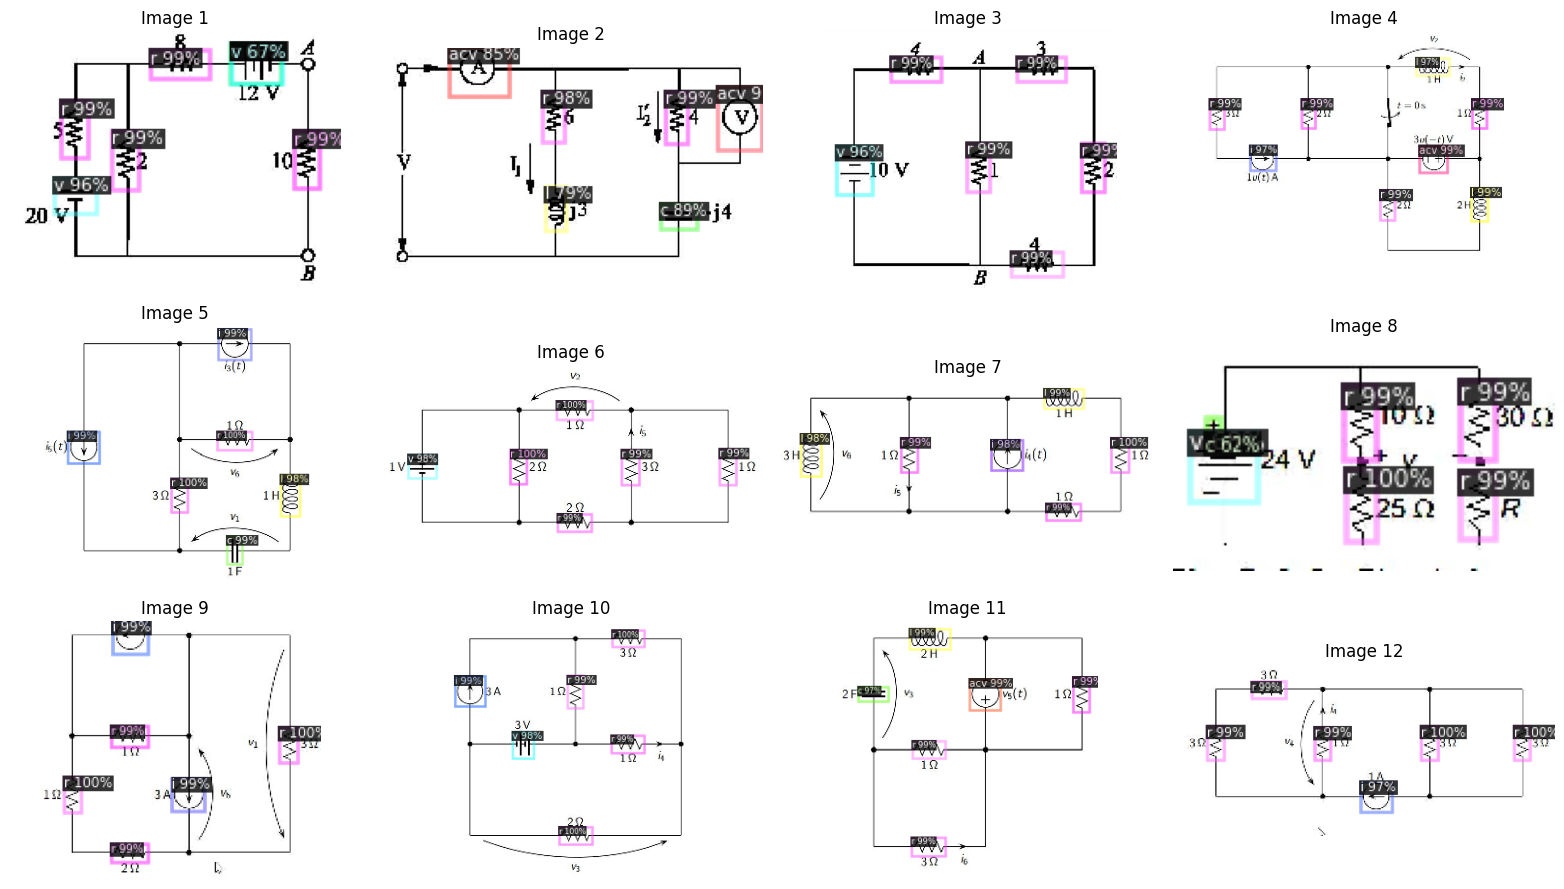

In [17]:
run_inference_on_random_images(12)

In [18]:
from detectron2.modeling import build_model
from detectron2.export import TracingAdapter
from detectron2.checkpoint import DetectionCheckpointer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "datasets/best_fasterrcnn_model.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

model = build_model(cfg)
model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load("datasets/best_fasterrcnn_model.pth")

[02/09 21:18:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/best_fasterrcnn_model.pth ...


{}

In [19]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 20.4 MB/s eta 0:00:00


In [20]:
# Detectron2 models take a list of dicts: [{"image": tensor}]
inputs = [{"image": torch.randn(3, 640, 640).to(cfg.MODEL.DEVICE)}]

# 3. Wrap the model with TracingAdapter
# This "flattens" the input/output so torch.onnx.export can understand it
adapter = TracingAdapter(model, inputs)

# 4. Use the adapter's flattened inputs for the export
dummy_inputs = adapter.flattened_inputs
onnx_model_path = "datasets/best_fasterrcnn_model.onnx"
torch.onnx.export(
    adapter,               # Export the adapter, not the raw model
    dummy_inputs,          # Use the flattened inputs
    onnx_model_path,
    opset_version=13,
    export_params=True,
    dynamo=False,        # Use legacy exporter to avoid strict tracing issues
    input_names=["input"],
    output_names=["boxes", "labels", "scores"],
    do_constant_folding=True,
)
print(f"ONNX export {onnx_model_path} completed successfully!")

/tmp/ipython-input-2192180902.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/usr/local/lib/python3.12/dist-packages/detectron2/structures/image_list.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:

ONNX export datasets/best_fasterrcnn_model.onnx completed successfully!


In [21]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 5.7 MB/s eta 0:00:00


In [22]:
import onnxruntime
import numpy as np
import cv2
import torch

# Load image and preprocess (assume 640x640)
img_path = "datasets/CircuitRecognitioncoco/valid/autockt_-73_png.rf.3f36271aeee48770cb53c483a7cf715a.jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (640, 640))
img_input = img_resized.astype(np.float32)
img_input = img_input.transpose(2, 0, 1)  # Result: (3, 640, 640)

# Run inference
session = onnxruntime.InferenceSession("datasets/best_fasterrcnn_model.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

# outputs is a list, often like [boxes, scores, keypoints]
print("Output:", [o.shape for o in outputs])

Output: [(6, 4), (6,), (6,), (2,)]


[5 5 5 2 3 4]
[0.9935162 0.9860151 0.9813996 0.9486035 0.9478695 0.8351197]


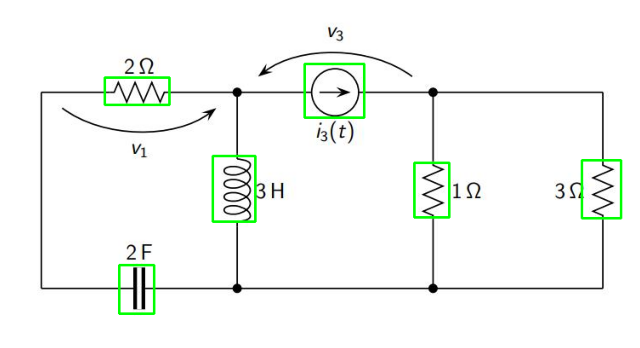

In [23]:
import torch
from torchvision.ops import nms
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Unpack outputs correctly
boxes, labels, scores, metainfo = outputs

# Convert to numpy arrays if needed
boxes = np.array(boxes)
labels = np.array(labels)
scores = np.array(scores)

# Apply NMS
boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
scores_tensor = torch.tensor(scores, dtype=torch.float32)
nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

# Filter after NMS
boxes = boxes_tensor[nms_indices].numpy()
scores = scores_tensor[nms_indices].numpy()
print(labels)
print(scores)

# Resize back to original scale
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / 640  # width scale
scale_y = h_orig / 640  # height scale

conf_thr = 0.3

for i in range(len(scores)):
    if scores[i] < conf_thr:
        continue

    # Draw bounding box
    x1, y1, x2, y2 = boxes[i]
    x1 = int(x1 * scale_x)
    y1 = int(y1 * scale_y)
    x2 = int(x2 * scale_x)
    y2 = int(y2 * scale_y)

    x1 = max(0, min(x1, w_orig - 1))
    y1 = max(0, min(y1, h_orig - 1))
    x2 = max(0, min(x2, w_orig - 1))
    y2 = max(0, min(y2, h_orig - 1))

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

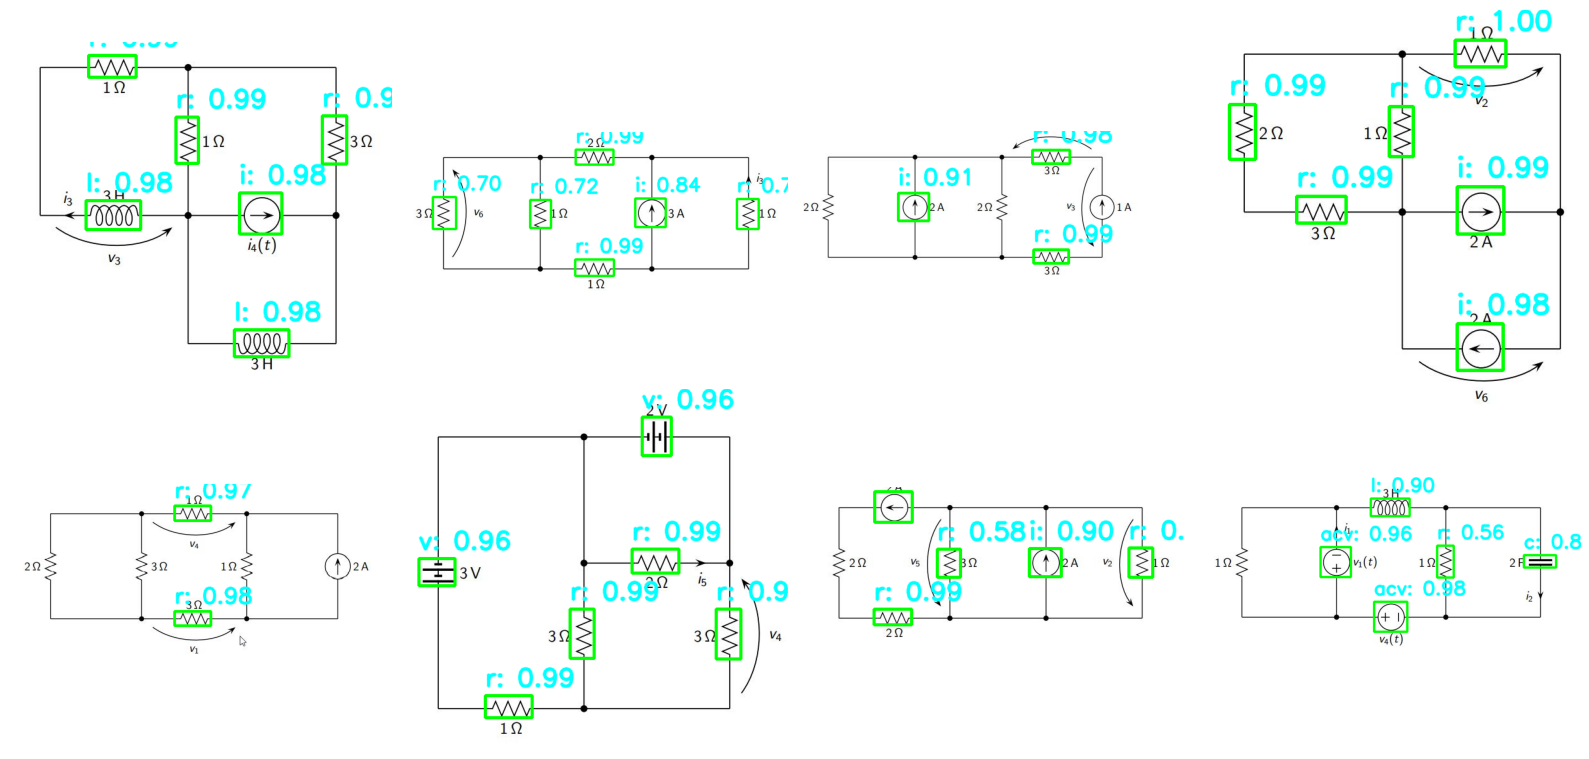

In [24]:
# class names
label_list= ["", "acv", "c", "i", "l", "r", "v"]

session = onnxruntime.InferenceSession("datasets/best_fasterrcnn_model.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name

# ---------------- CONFIG ----------------
val_dir = "datasets/CircuitRecognitioncoco/valid/"

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(sample_imgs):
    plt.subplot(2, 4, i+1)

    img = cv2.imread(image)
    img_resized = cv2.resize(img, (640, 640))
    img_input = img_resized.astype(np.float32)
    img_input = img_input.transpose(2, 0, 1)

    outputs = session.run(None, {input_name: img_input})

    boxes, labels, scores, metainfo = outputs

    # Convert to numpy arrays if needed
    boxes = np.array(boxes)
    labels = np.array(labels)
    scores = np.array(scores)

    # Apply NMS
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

    # Filter after NMS
    boxes = boxes_tensor[nms_indices].numpy()
    scores = scores_tensor[nms_indices].numpy()

    # Resize back to original scale
    h_orig, w_orig = img.shape[:2]
    scale_x = w_orig / 640  # width scale
    scale_y = h_orig / 640  # height scale

    conf_thr = 0.3

    for ii in range(len(scores)):
        if scores[ii] < conf_thr:
            continue

        label = label_list[labels[ii]]
        score = scores[ii]

        # Draw bounding box
        x1, y1, x2, y2 = boxes[ii]
        x1 = int(x1 * scale_x)
        y1 = int(y1 * scale_y)
        x2 = int(x2 * scale_x)
        y2 = int(y2 * scale_y)

        x1 = max(0, min(x1, w_orig - 1))
        y1 = max(0, min(y1, h_orig - 1))
        x2 = max(0, min(x2, w_orig - 1))
        y2 = max(0, min(y2, h_orig - 1))

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # draw label and score
        text = f"{label}: {score:.2f}"
        cv2.putText(img, text, (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX,
                    1.3, (255, 255, 0), 3, cv2.LINE_AA)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()